# Connect to database

In [25]:
from query_database import QueryDatabase
from database import Database
from constants import DATABASE_PATH

df = QueryDatabase("SELECT * FROM supplier_invoice.invoice_202408;").df
df.head()

,Förvaltning,Leverantör,Organisationsnummer,Verifikationsnummer,Konto,Kontotext,Belopp exkl moms
0,Stadsmiljönämnden,TRACK TEC GMBH,106/5727/0626,4001291513,4101,Inköp anläggnings och underhållsmaterial,"9 835 315,00"
1,Kretslopp och Vatten,POLISMYNDIGHETEN I VÄSTRA GÖTALAND,2021000076,5601378982,6185,Anläggningsentreprenad,"870,00"
2,Kretslopp och Vatten,POLISMYNDIGHETEN I VÄSTRA GÖTALAND,2021000076,5601377374,6185,Anläggningsentreprenad,"870,00"
3,Kretslopp och Vatten,POLISMYNDIGHETEN I VÄSTRA GÖTALAND,2021000076,5601378519,6185,Anläggningsentreprenad,"870,00"
4,Exploateringsnämnden,POLISMYNDIGHETEN I VÄSTRA GÖTALAND,2021000076,2001226894,7641,Diverse skatter och offentliga avgifter,"1 000,00"


In [26]:
df.shape

(92989, 7)

## Clean cost column

In [27]:
df.loc[:, "Belopp exkl moms"] = df["Belopp exkl moms"].str[:-3].str.replace(" ", "").astype(int)
df.head() # Loc to select the whole column


,Förvaltning,Leverantör,Organisationsnummer,Verifikationsnummer,Konto,Kontotext,Belopp exkl moms
0,Stadsmiljönämnden,TRACK TEC GMBH,106/5727/0626,4001291513,4101,Inköp anläggnings och underhållsmaterial,9835315
1,Kretslopp och Vatten,POLISMYNDIGHETEN I VÄSTRA GÖTALAND,2021000076,5601378982,6185,Anläggningsentreprenad,870
2,Kretslopp och Vatten,POLISMYNDIGHETEN I VÄSTRA GÖTALAND,2021000076,5601377374,6185,Anläggningsentreprenad,870
3,Kretslopp och Vatten,POLISMYNDIGHETEN I VÄSTRA GÖTALAND,2021000076,5601378519,6185,Anläggningsentreprenad,870
4,Exploateringsnämnden,POLISMYNDIGHETEN I VÄSTRA GÖTALAND,2021000076,2001226894,7641,Diverse skatter och offentliga avgifter,1000


In [32]:
with Database(DATABASE_PATH) as db:
    db.connection.register('df', df)
    
    db.query("CREATE SCHEMA IF NOT EXISTS refined_layer;")
    db.query(
        f"""                
    CREATE TABLE IF NOT EXISTS refined_layer.invoice_202408
    AS SELECT * FROM df;
    """
    )

In [36]:
QueryDatabase("SELECT * FROM refined_layer.invoice_202408;").df


,Förvaltning,Leverantör,Organisationsnummer,Verifikationsnummer,Konto,Kontotext,Belopp exkl moms
0,Stadsmiljönämnden,TRACK TEC GMBH,106/5727/0626,4001291513,4101,Inköp anläggnings och underhållsmaterial,9835315
1,Kretslopp och Vatten,POLISMYNDIGHETEN I VÄSTRA GÖTALAND,2021000076,5601378982,6185,Anläggningsentreprenad,870
2,Kretslopp och Vatten,POLISMYNDIGHETEN I VÄSTRA GÖTALAND,2021000076,5601377374,6185,Anläggningsentreprenad,870
3,Kretslopp och Vatten,POLISMYNDIGHETEN I VÄSTRA GÖTALAND,2021000076,5601378519,6185,Anläggningsentreprenad,870
4,Exploateringsnämnden,POLISMYNDIGHETEN I VÄSTRA GÖTALAND,2021000076,2001226894,7641,Diverse skatter och offentliga avgifter,1000
...,...,...,...,...,...,...,...
92984,Stadsmiljönämnden,VIANOVA,SAKNAS,4001295782,7432,IT tjänster,-263400
92985,Stadsmiljönämnden,VIANOVA,SAKNAS,4001290661,7432,IT tjänster,263400
92986,Stadsfastighetsnämnden,WINDOWMASTER A/S,SAKNAS,2302185009,6151,Mindre reparation o underhåll fastighet,23518
92987,Stadsfastighetsnämnden,WINDOWMASTER A/S,SAKNAS,2302185009,2677,"Beräknad utg moms tjänsteinköp i Sverige, 25%",-5879


In [37]:
df = QueryDatabase(
    """
    SELECT 
        leverantör, 
        SUM("Belopp exkl moms") AS "Summa (kr)"
        FROM 
            refined_layer.invoice_202408 
        GROUP BY 
            leverantör
        ORDER BY 
            "Summa (kr)"
        DESC
        ;
    """
).df

df

,Leverantör,Summa (kr)
0,GÖTEBORGS STADS LEASING AB,62433766.0
1,KPA PENSIONSSERVICE AB,59741750.0
2,RÄDDNINGSTJÄNSTEN STORGÖTEBORG,55320824.0
3,PURAC AB,48603208.0
4,RENOVA,34435107.0
...,...,...
2914,LILLA EDETS KOMMUN,-16555.0
2915,ARBETSLIVSRESURS AR AB,-19384.0
2916,KINNARPS AB,-78016.0
2917,BRF KARLAGATAN 10-12,-298927.0


<Axes: title={'center': 'Top 5 spending in Göteborgs kommun'}, ylabel='Leverantör'>

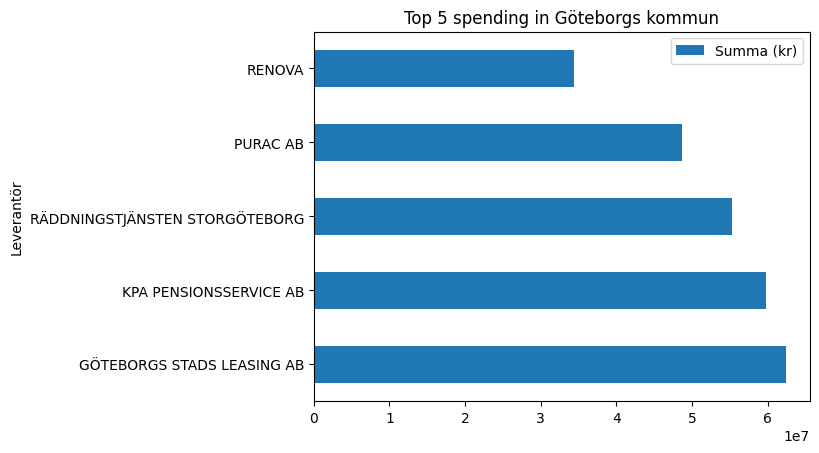

In [38]:
df.head().plot(kind="barh", x="Leverantör", y="Summa (kr)", title="Top 5 spending in Göteborgs kommun")